In [1]:
import matplotlib.pyplot as plt
import json
import os
import matplotlib

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Input Assumptions

The model was run 336 times for each "site" [SSEB, Cafe, Cafe+SSEB], where the Cafe's critical load was generated by randomly repeating Saturday and Sunday profiles within each month (eg. June consists of all of the 2019 Saturdays and Sundays in June, shuffled, and placed end to end for 30 days). For each of the 336 runs constraints were set such that the load must be met with solar PV + BESS for 25-26 consecutive two-week outage periods, where the first of the 336 runs had the two week periods starting at January 1st, midnight. Then the second of the 336 runs started the outages at 1am on January 1st, and so on. Each outage starts with the battery system charged to 70% of capacity. Each scenario provides the minimum cost system to meet the critical load in all of the 2 week outages modeled.

In [3]:
pv_cost_per_kw = 1600
batt_cost_per_kw = 840
batt_cost_per_kwh = 420

{  
  "PV": {
    "macrs_option_years": 5,
    "existing_kw": 16,
    "macrs_bonus_pct": 1.0,
    "total_itc_pct": 0.26
  },
  "Storage": {
    "macrs_option_years": 5,
    "can_grid_charge": False,
    "total_itc_pct": 0.26,
    "replace_cost_per_kw": 410.0,  # in year 10
    "replace_cost_per_kwh": 200.0
  },
  "Financial": {
    "microgrid_premium_pct": 0.3,
    "analysis_years": 25,
    "om_cost_escalation_pct": 0.025,
    "elec_cost_escalation_pct": 0.023,
    "offtaker_tax_pct": 0.26,
    "owner_discount_pct": 0.1,
    "offtaker_discount_pct": 0.03,
    "two_party_ownership": True,
    "offtaker_tax_pct": 0.0
  }
};

In [4]:
results_dir = "sseb_results"
plt_prefix = "sseb"

In [5]:
results = []
for j in [f for f in os.listdir(results_dir) if f.startswith("sseb_tzero")]:
    results.append(json.load(open(os.path.join(results_dir, j), 'r')))

pvs_kw = [r["PV_kw"] for r in results]
batt_kws = [r["batt_kw"] for r in results]
batt_kwhs = [r["batt_kwh"] for r in results]

net_capital_costs = [r["net_capital_costs"] for r in results]



upfront_costs = []

for pv,bkw,bkwh in zip(pvs_kw, batt_kws, batt_kwhs):
    upfront_costs.append( 1.3 *
        (pv*pv_cost_per_kw + bkw*batt_cost_per_kw + bkwh*batt_cost_per_kwh)
    )

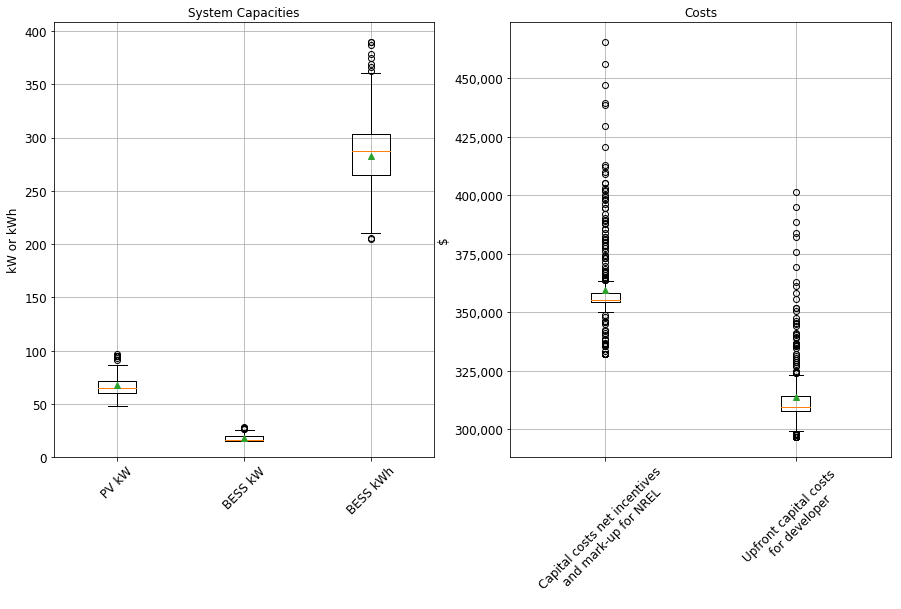

In [6]:
fig, axes = plt.subplots(1,2, figsize=(15, 8))
miny = 0

axes[0].set_title("System Capacities")
bp = axes[0].boxplot([
    pvs_kw, 
    batt_kws,
    batt_kwhs,
], showmeans=True)

ylims = axes[0].get_ylim()
axes[0].set_ylim((miny, ylims[1]))

axes[1].set_title("Costs")
bp = axes[1].boxplot([
    net_capital_costs, 
    upfront_costs
], showmeans=True)

# axes[1].set_ylim((miny, ylims[1]))

for ax in axes:
    ax.grid()

    
axes[0].set_xticklabels(["PV kW", 
                    "BESS kW",
                    "BESS kWh",
                    ], 
                   rotation=45
                  )
axes[0].set_ylabel("kW or kWh", fontsize=BIGGER_SIZE)

axes[1].set_xticklabels(["Capital costs net incentives\n and mark-up for NREL", 
                         "Upfront capital costs \nfor developer"
                    ], 
                   rotation=45
                  )
axes[1].set_ylabel("$", fontsize=BIGGER_SIZE)


axes[1].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# plt.title("time_compare_test_generator_big_enough_for_outage")
#     ax.set_xlim((-500, 500))
plt.savefig(plt_prefix+"_2wk_outages_robust_for_24_per_year.pdf", bbox_inches="tight")

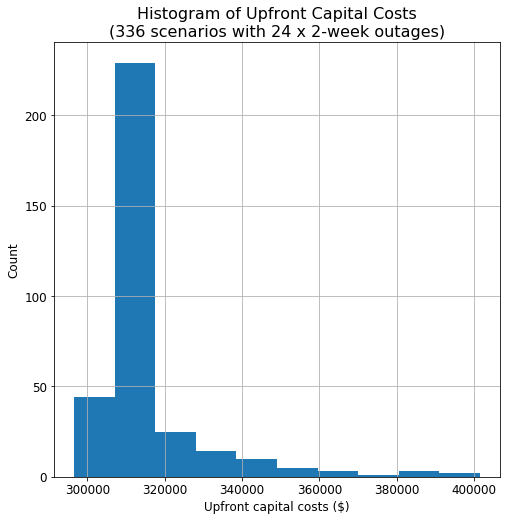

In [7]:
plt.figure(figsize=(8,8))
plt.hist(upfront_costs)
plt.xlabel("Upfront capital costs ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Upfront Capital Costs\n(336 scenarios with 24 x 2-week outages)",
         fontsize=16)
plt.grid()
plt.savefig(plt_prefix+"_hist_upfront_costs.pdf", bbox_inches="tight")

Notes: 
- upfront capital costs include 30% microgrid cost-adder to the default cost values.
- Cost to NREL includes developer's IRR as well as developer's tax benefits (ITC, MACRS)
- Existing 16 kW of PV is included in the capacities plot (but is not part of costs)